# __INFO 2950 FINAL PROJECT PHASE II__

## Research Questions:

**Questions**: To what extent do income levels correlate with average distance to the nearest grocery store across census tracts in New York State? What about income levels and density of grocery stores within census tracts in New York State? Are there significant disparities among different racial groups?

**Purpose**:
This research aims to explore how income levels and racial composition correlate with access to grocery stores in New York State. Specifically, the study will investigate the relationship between income and both the average distance to the nearest grocery store and the density of grocery stores within census tracts. It will also analyze how the racial composition of census tracts is associated with the density of grocery stores within a 1-mile radius, identifying any disparities among racial groups.

**General Process**:
Grocery store locations will be matched with census tract data to estimate access to grocery stores across socioeconomic and demographic groups. Census tract centers will serve as proxies for residential locations, and we will extract socioeconomic data and calculate the distances between tract centers and grocery stores using latitude and longitude. The density of stores per tract and within a 1-mile radius will be calculated using geospatial analysis tools.

**Potential Applications**:
The final output will be insights into food accessibility and inequality across different groups, helping to identify areas where communities might face barriers to healthy food access. These insights will be valuable for policymakers or non-profits working on food equity issues in New York State.

# Data Descriptions

## 1. Retail Food Stores Data

### Source
https://data.ny.gov/Economic-Development/Retail-Food-Stores/9a8c-vfzj/about_data

### What are the observations (rows) and the attributes (columns)?
- **Observations:** Each row represents a single retail food store location in New York state.
- **Attributes:** 
  - Store name
  - Latitude and longitude

### Why was this dataset created?
The dataset was created to provide insights into grocery stores licensed by New York State. Its purposes include promoting transparency, facilitating economic analysis, informing policy-making, and aiding in business planning.

### Who funded the creation of the dataset?
The dataset is provided and funded by the New York State Department of Agriculture and Markets, specifically owned by the Division of Food Safety & Inspection.

### What processes might have influenced what data was observed and recorded and what was not?
1. Licensing requirements: Only stores with proper licensing are included, potentially missing unofficial or unlicensed food sources.
2. Categorization criteria: The definition and categorization of what qualifies as a grocery store (e.g., supermarkets vs. convenience stores) could impact density metrics.
3. Registration processes: Smaller or independently owned stores might be underrepresented if they face barriers to registration or licensing.

### What preprocessing was done, and how did the data come to be in the form that you are using?
1. Filtering: Non-grocery establishments were removed to focus on relevant food retail locations.
2. Geospatial processing: Stores were assigned to census tracts through geospatial joins.
3. Distance calculations: Distances between tract centers and grocery stores were computed.
4. Aggregation: Store locations were aggregated to each census tract for density analysis.
5. R programming: Used to summarize the data into relevant metrics for analysis.

### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
Store owners and managers are aware that their licensing information is collected by the state. They would expect this data to be used for regulatory purposes, public information, and potentially for research or business planning purposes.

### Where can your raw source data be found?
The raw data can be accessed from the New York State Open Data portal at: https://data.ny.gov/Economic-Development/Retail-Food-Stores/9a8c-vfzj/about_data

## 2. Census Data

### Source
https://data.census.gov/table?q=United%20States&g=010XX00US_040XX00US36$1400000

### What are the observations (rows) and the attributes (columns)?
- **Observations:** Each row represents a census tract in New York State.
- **Attributes:** 
  - Census tract identifier
  - Median income of the tract
  - State 
  - County
  - Racial populations of the tract (White, Black, Native, Asian)
  - Racial composition of the tract (percentages of each racial group, White, Black, Native, Asian)

### Why was this dataset created?
The U.S. Census data was created to collect detailed demographics and additional information on the composition of small areas (tracts) within the U.S. It serves various purposes including resource allocation, policy-making, and academic research.

### Who funded the creation of the dataset?
The census data comes from the U.S. Census Bureau, which is a U.S. government-funded agency.

### What processes might have influenced what data was observed and recorded and what was not?
1. Digital collection methods: May introduce slight inaccuracies due to technological limitations or user error.
2. Lack of enforcement: While census participation is mandatory by law, non-participation is rarely prosecuted, potentially leading to underrepresentation.
3. Population mobility: Immigration/emigration between census periods can affect data accuracy.
4. Self-reporting: Reliance on individuals to provide accurate information about themselves and their households.

### What preprocessing was done, and how did the data come to be in the form that you are using?
1. Data selection: Relevant demographic variables were extracted from the broader census dataset.
2. Calculation of derived metrics: Population density and racial percentages were calculated from raw data.
3. Integration: Census data was matched with grocery store data based on geographic identifiers.
4. R programming: Used to process and summarize the census data for analysis.

### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
People were involved in the census data collection. The Census Bureau used mail and digital communication methods to contact households about census participation. Respondents are informed that the data will be used for various governmental and public purposes, including the allocation of federal funds and planning of public services.

### Where can your raw source data be found?
The raw census data can be accessed through the U.S. Census Bureau's website - https://data.census.gov/table?q=United%20States&g=010XX00US_040XX00US36$1400000



### Importing

In [46]:
#importing packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
from shapely.geometry import shape
import os
import duckdb as db

## Data Cleaning



### Data Cleaning: Retail Food Stores in New York State
Source List of Grocery Stores Provided by New York State:

https://data.ny.gov/Economic-Development/Retail-Food-Stores/9a8c-vfzj/about_data

This contains a csv file of every grocery store location in New York state that could be then paired with census tract data to look at how average distance to grocery stores changes by different socioeconomic groups. We will use census tract centers as an approximation for where everyone in the tract lives and then use the census data to get information on population statistics.

#### Step 1: Loading in the Data

Our primary grocery store dataset comes from the New York State Open Data portal, specifically the "Retail Food Stores" dataset. This dataset provides information about licensed retail food stores across New York State. This step loads our raw data into a pandas DataFrame. Understanding the initial shape is to check later on that our cleaning is actaully changing the dataframe.

In [86]:
# Loading in the dataset
stores = pd.read_csv('https://data.ny.gov/api/views/9a8c-vfzj/rows.csv?accessType=DOWNLOAD')

# Displays the shape of the original raw data for the retail stores
print("Initial dataset shape:", stores.shape)

Initial dataset shape: (24221, 15)


#### Step 2: Selecting Relevant Columns
For our analysis of grocery store access we really only need the store name and location as this will be used to find the distance of how far the store is from the center of the census tract. We will extract these from the 'Entity Name' and 'Georeference' columns.

In [87]:
# Selecting relevant columns
stores = stores[['Entity Name', 'Georeference']]

# Renaming the columns for clarity
stores = stores.rename(columns={'Entity Name': 'name'})

print(stores.head())

                   name                        Georeference
0         ANK PETRO INC   POINT (-73.816249346 42.46925125)
1           EVANS JULIA  POINT (-73.949128787 42.577416307)
2            HUBRIX LLC  POINT (-77.795356304 42.158830586)
3       REID STORES INC  POINT (-78.277036649 42.220633641)
4  361 DELI GROCERY LLC  POINT (-73.877219853 40.871759695)


#### Step 3: Handling Missing Data
To ensure the accuracy of our spatial analysis in the next steps, we need to clean the data table to remove any stores with missing location data by dropping the NaN values. 

In [88]:
# Remove rows with missing Georeference
stores = stores.dropna(subset=['Georeference'])

print("Dataset shape after removing missing Georeference values:")
print(stores.shape)

Dataset shape after removing missing Georeference values:
(24221, 2)


#### Step 4: Extracting Latitude and Longitude
To make the location data a more usuable format that we can calculate distance with with the census tract data, we have to extract the latitude and longitude from the Georeference column, and then drop that column.

In [89]:
# Extract latitude and longitude from Georeference
def extract_coordinates(georeference):
    coords = georeference.strip('POINT ()').split()
    return pd.Series({'longitude': float(coords[0]), 'latitude': float(coords[1])})

stores[['longitude', 'latitude']] = stores['Georeference'].apply(extract_coordinates)

# Dropping the OG Georeference column 
stores = stores.drop('Georeference', axis=1)

print(stores.head())

                   name  longitude   latitude
0         ANK PETRO INC -73.816249  42.469251
1           EVANS JULIA -73.949129  42.577416
2            HUBRIX LLC -77.795356  42.158831
3       REID STORES INC -78.277037  42.220634
4  361 DELI GROCERY LLC -73.877220  40.871760


#### Step 5: Cleaned Retail Grocery Store Data Check
Our final dataset contains the name, latitude, and longitude of each retail food store in New York State. This data set will be used to calculate distances between stores and census tract centroids.

When combined with census data, this will enable us to investigate how store locations correlate with various socioeconomic factors, addressing our research questions about food access across different demographic groups in New York State.

The next steps are to merge this cleaned store data with census tract data to begin our analysis of the relationship between store locations and socioeconomic factors.

In [91]:
# Info about the cleaned grocery stores dataset
print("Cleaned dataset shape:", stores.shape)
print("Cleaned column names:")
print(stores.columns.tolist())

# First few rows of cleaned grocery dataset
print("First few rows of the cleaned dataset:")
print(stores.head().to_string())

# Saving the cleaned dataset to a csv file to use later 
stores.to_csv('cleaned_retail_stores.csv', index=False)

Cleaned dataset shape: (24221, 3)
Cleaned column names:
['name', 'longitude', 'latitude']
First few rows of the cleaned dataset:
                   name  longitude   latitude
0         ANK PETRO INC -73.816249  42.469251
1           EVANS JULIA -73.949129  42.577416
2            HUBRIX LLC -77.795356  42.158831
3       REID STORES INC -78.277037  42.220634
4  361 DELI GROCERY LLC -73.877220  40.871760


### Data Cleaning: Census Data for New York State

#### Step 1: Loading in Census Data through Census API

We'll use the Census API to collect demographic data for New York State census tracts, focusing on median household income and racial composition data. This step retrieves census data for all tracts in New York State, including median household income and population counts by race.

In [92]:

# Census API endpoint and parameters
api_key = "273983b851bd05f546e743ac334b18277e8c67d1"  
base_url = "https://api.census.gov/data/2021/acs/acs5"
variables = ["NAME", "B19013_001E", "B02001_002E", "B02001_003E", "B02001_005E", "B03003_003E"]
state = "36" 

# API URL
url = f"{base_url}?get={','.join(variables)}&for=tract:*&in=state:{state}&key={api_key}"

# Making the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Creating the DataFrame
    census_df = pd.DataFrame(data[1:], columns=data[0])
else:
    print(f"Error: Unable to get data. Status code: {response.status_code}")
    print(response.text)
    exit()

#### Step 2: Renaming and Selecting Columns
Renaming the columns to names that make sense to the average person and select only the ones we need for our analysis. This step focuses our dataset on the demographic information relevant to our research question about food access across different socioeconomic groups which in this case is the median income, white population, black population, asian population, and hispanic population. 

In [96]:
# Renaming the columns
column_names = {
    "B19013_001E": "median_income",
    "B02001_002E": "white_pop",
    "B02001_003E": "black_pop",
    "B02001_005E": "asian_pop",
    "B03003_003E": "hispanic_pop"
}

census_df = census_df.rename(columns=column_names)

# Selecting the relevant columns
census_df = census_df[["NAME", "median_income", "white_pop", "black_pop", "asian_pop", "hispanic_pop", "tract"]]

print(census_df.head())

                                         NAME  median_income  white_pop  \
0     Census Tract 1, Albany County, New York        44871.0      530.0   
1  Census Tract 2.01, Albany County, New York        42456.0      521.0   
2  Census Tract 2.02, Albany County, New York        24792.0      124.0   
3  Census Tract 3.01, Albany County, New York        40666.0     1155.0   
4  Census Tract 3.02, Albany County, New York        42370.0     2180.0   

   black_pop  asian_pop  hispanic_pop   tract  
0     1086.0       87.0         311.0  000100  
1     1945.0      109.0         165.0  000201  
2     2316.0        0.0          71.0  000202  
3     1251.0      221.0         836.0  000301  
4      457.0      387.0         155.0  000302  


#### Step 3: Data Type Conversion
We need to convert the numeric columns to the appropriate data type for analysis which in this case is a float as we will be calculating the percentage of the racial populations in a future step.

In [97]:
# Converting the numeric columns to float values
numeric_columns = ["median_income", "white_pop", "black_pop", "asian_pop", "hispanic_pop"]
census_df[numeric_columns] = census_df[numeric_columns].astype(float)

#Sanity check
print("Data types after conversion:")
print(census_df.dtypes)

Data types after conversion:
NAME              object
median_income    float64
white_pop        float64
black_pop        float64
asian_pop        float64
hispanic_pop     float64
tract             object
dtype: object


#### Step 3: Handling Missing Values
Checking for and handle any missing values in our dataset as that would lead to problems when plotting the data later on and do not want to use data that misses crucial info for our analysis

In [102]:
# Replace -666666666 (Census placeholder for missing data) with NaN
census_df = census_df.replace(-666666666, np.nan)

# Drop the rows with the missing median income
census_df = census_df.dropna(subset=["median_income"])

# Check for missing values
print("Missing values:")
print(census_df.isnull().sum())

# Dataset shape after handling missing values 
print(census_df.shape)

Missing values:
NAME             0
median_income    0
white_pop        0
black_pop        0
asian_pop        0
hispanic_pop     0
tract            0
dtype: int64
(5198, 7)


#### Step 4: Creating Derived Variables
Creating percentage variables for racial composition to facilitate our analysis.

In [56]:
# Calculate total population
census_df["total_pop"] = census_df[["white_pop", "black_pop", "asian_pop", "hispanic_pop"]].sum(axis=1)

# Calculate percentage for each race/ethnicity
for group in ["white", "black", "asian", "hispanic"]:
    census_df[f"{group}_percent"] = census_df[f"{group}_pop"] / census_df["total_pop"] * 100

print("\nDataset after creating percentage variables:")
print(census_df.head())

# Save the cleaned census data
census_df.to_csv('cleaned_census_data.csv', index=False)


Dataset after creating percentage variables:
                                         NAME  median_income  white_pop  \
0     Census Tract 1, Albany County, New York        44871.0      530.0   
1  Census Tract 2.01, Albany County, New York        42456.0      521.0   
2  Census Tract 2.02, Albany County, New York        24792.0      124.0   
3  Census Tract 3.01, Albany County, New York        40666.0     1155.0   
4  Census Tract 3.02, Albany County, New York        42370.0     2180.0   

   black_pop  asian_pop  hispanic_pop state county   tract  total_pop  \
0     1086.0       87.0         311.0    36    001  000100     2014.0   
1     1945.0      109.0         165.0    36    001  000201     2740.0   
2     2316.0        0.0          71.0    36    001  000202     2511.0   
3     1251.0      221.0         836.0    36    001  000301     3463.0   
4      457.0      387.0         155.0    36    001  000302     3179.0   

   white_percent  black_percent  asian_percent  hispanic_percent

These percentage variables will allow us to analyze food access patterns across different racial compositions in census tracts.

#### Step 5: Finding Center of Census Tracts 
Now that we have a cleaned dataset we have to find the center of each census tract to serve as a proxy to where everyone in that census tract lives and in turn how far they are from a grocery store. 

In [57]:
#Load in shapefile for New York Census Tracts 
shapefile_path = "tl_2021_36_tract.shp"  
tracts_gdf = gpd.read_file(shapefile_path)

#gets points in 3D space 
tracts_gdf = tracts_gdf.to_crs(epsg=5070)

# Calculates centroids of each census tract
tracts_gdf['centroid'] = tracts_gdf.geometry.centroid

#gets tract number so can match with census information last 6 values of GEOID information census data 
tracts_gdf['tract_number'] = tracts_gdf['GEOID'].str[-6:]

# Take out tract number and centroid columns
centroid_df = tracts_gdf[['tract_number', 'centroid']]
print(centroid_df.head())

  tract_number                         centroid
0       069601  POINT (1835948.861 2171541.933)
1       069602  POINT (1836565.723 2171170.171)
2       079801   POINT (1831518.497 2174267.51)
3       079802  POINT (1831354.054 2173996.174)
4       105801  POINT (1838171.439 2174599.774)


## Step 6: Merging DataFrames 
The census data needs to be merged with data on the center of each census tract. The data is merged on tract values. 

In [58]:
# Ensures that the 'tract' in census_df and 'tract_number' in centroid_df are of the same type
census_df['tract'] = census_df['tract'].astype(str)
centroid_df['tract_number'] = centroid_df['tract_number'].astype(str)

# Performing the merge
merged_df = pd.merge(census_df, 
                  centroid_df[['tract_number', 'centroid']], 
                  left_on='tract', 
                  right_on='tract_number', 
                  how='left')

# Create a copy of the merged dataframe
merged_df = merged_df.copy()

# Dropping the redundant 'tract_number' column
merged_df = merged_df.drop(columns=['tract_number'])

print(merged_df.head())

# Saving as a CSV file 
merged_df.to_csv('merged_census_centroid.csv', index=False)

                                      NAME  median_income  white_pop  \
0  Census Tract 1, Albany County, New York        44871.0      530.0   
1  Census Tract 1, Albany County, New York        44871.0      530.0   
2  Census Tract 1, Albany County, New York        44871.0      530.0   
3  Census Tract 1, Albany County, New York        44871.0      530.0   
4  Census Tract 1, Albany County, New York        44871.0      530.0   

   black_pop  asian_pop  hispanic_pop state county   tract  total_pop  \
0     1086.0       87.0         311.0    36    001  000100     2014.0   
1     1086.0       87.0         311.0    36    001  000100     2014.0   
2     1086.0       87.0         311.0    36    001  000100     2014.0   
3     1086.0       87.0         311.0    36    001  000100     2014.0   
4     1086.0       87.0         311.0    36    001  000100     2014.0   

   white_percent  black_percent  asian_percent  hispanic_percent  \
0      26.315789      53.922542       4.319762         15.44

/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Step 7: 
Now the closest grocery store and the average distance to each census tract needs to be found


In [72]:
from shapely.geometry import Point

# Load in shapefile for New York Census Tracts 
shapefile_path = "tl_2021_36_tract.shp"  
tracts_gdf = gpd.read_file(shapefile_path)

# Convert to EPSG:5070
tracts_gdf = tracts_gdf.to_crs(epsg=5070)

# Calculate centroids of each census tract
tracts_gdf['centroid'] = tracts_gdf.geometry.centroid

# Get tract number (last 6 values of GEOID)
tracts_gdf['tract_number'] = tracts_gdf['GEOID'].str[-6:]

# Extract tract number and centroid columns
centroid_df = tracts_gdf[['tract_number', 'centroid']].copy()

# Convert centroids to latitude and longitude (WGS84, EPSG:4326)
centroid_df['centroid'] = centroid_df['centroid'].to_crs(epsg=4326)

# Extract latitude and longitude from the centroid points
centroid_df['longitude'] = centroid_df['centroid'].x
centroid_df['latitude'] = centroid_df['centroid'].y

# Drop the original centroid column
centroid_df = centroid_df.drop('centroid', axis=1)

print("Centroid data:")
print(centroid_df.head())

# Load the stores data 
stores = pd.read_csv('cleaned_retail_stores.csv')

print("\nStores data:")
print(stores.head())

# Create GeoDataFrames for both datasets
centroid_gdf = gpd.GeoDataFrame(
    centroid_df, 
    geometry=gpd.points_from_xy(centroid_df.longitude, centroid_df.latitude),
    crs="EPSG:4326"
)

stores_gdf = gpd.GeoDataFrame(
    stores, 
    geometry=gpd.points_from_xy(stores.longitude, stores.latitude),
    crs="EPSG:4326"
)

# Convert both GeoDataFrames to a projected CRS 
centroid_gdf = centroid_gdf.to_crs(epsg=32618)  # UTM zone New York 
stores_gdf = stores_gdf.to_crs(epsg=32618)

# Now you can perform spatial operations, for example, finding the nearest store to each tract centroid
centroid_gdf['nearest_store'] = centroid_gdf.apply(
    lambda row: stores_gdf.distance(row.geometry).idxmin(), axis=1
)

# Add the name of the nearest store
centroid_gdf['nearest_store_name'] = centroid_gdf['nearest_store'].apply(lambda idx: stores_gdf.loc[idx, 'name'])

print("\nCentroid data with nearest store:")
print(centroid_gdf.head())

# Calculate the distance to the nearest store (in meters)
centroid_gdf['distance_to_nearest_store'] = centroid_gdf.apply(
    lambda row: stores_gdf.loc[row['nearest_store'], 'geometry'].distance(row.geometry),
    axis=1
)

print("\nCentroid data with nearest store and distance:")
print(centroid_gdf.head())

# Convert back to WGS84 for saving 
centroid_gdf = centroid_gdf.to_crs(epsg=4326)

# Save the result
centroid_gdf.to_csv('census_tracts_with_nearest_store.csv', index=False)

Centroid data:
  tract_number  longitude   latitude
0       069601 -73.914786  40.627228
1       069602 -73.908651  40.622730
2       079801 -73.958719  40.660011
3       079802 -73.961371  40.657991
4       105801 -73.880596  40.649220

Stores data:
                   name  longitude   latitude
0         ANK PETRO INC -73.816249  42.469251
1           EVANS JULIA -73.949129  42.577416
2            HUBRIX LLC -77.795356  42.158831
3       REID STORES INC -78.277037  42.220634
4  361 DELI GROCERY LLC -73.877220  40.871760

Centroid data with nearest store:
  tract_number  longitude   latitude                        geometry  \
0       069601 -73.914786  40.627228  POINT (591781.302 4497943.187)   
1       069602 -73.908651  40.622730  POINT (592306.371 4497450.251)   
2       079801 -73.958719  40.660011  POINT (588022.553 4501537.351)   
3       079802 -73.961371  40.657991   POINT (587800.97 4501310.438)   
4       105801 -73.880596  40.649220  POINT (594641.881 4500420.695)   

   ne

The Census Tract Centroid and Store Location Comparison script is crucial for addressing these research questions as it provides the foundational data linking census tracts to their nearest grocery stores. By calculating the distance between each census tract centroid and the nearest store, it enables the analysis of how income levels correlate with grocery store accessibility across New York State. 


#### Step 8. Cleaning and merging the nearest grocery store data


In [71]:
# Loading the new census grocery store distance CSV file
store_distance_df = pd.read_csv('census_tracts_with_nearest_store.csv')

# Loading the cleaned census data CSV file
census_data_df = pd.read_csv('cleaned_census_data.csv')

# Ensure the tract number columns in both dataframes are of the same type
store_distance_df['tract_number'] = store_distance_df['tract_number'].astype(str)
census_data_df['tract'] = census_data_df['tract'].astype(str)

# Merge the dataframes on the tract number
merged_df = pd.merge(census_data_df, store_distance_df, left_on='tract', right_on='tract_number', how='left')

# Drop unnecessary columns
columns_to_drop = ['tract_number', 'longitude', 'latitude', 'geometry', 'state', 'county']
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

# Check for any unmatched census tracts
unmatched_tracts = merged_df[merged_df['nearest_store'].isna()]

# Display the first few rows of the merged dataframe
print(merged_df.head())

# Save the merged dataframe to a new CSV file
output_file = 'merged_census_store_data.csv'
merged_df.to_csv(output_file, index=False)

                                      NAME  median_income  white_pop  \
0  Census Tract 1, Albany County, New York        44871.0      530.0   
1  Census Tract 1, Albany County, New York        44871.0      530.0   
2  Census Tract 1, Albany County, New York        44871.0      530.0   
3  Census Tract 1, Albany County, New York        44871.0      530.0   
4  Census Tract 1, Albany County, New York        44871.0      530.0   

   black_pop  asian_pop  hispanic_pop tract  total_pop  white_percent  \
0     1086.0       87.0         311.0   100     2014.0      26.315789   
1     1086.0       87.0         311.0   100     2014.0      26.315789   
2     1086.0       87.0         311.0   100     2014.0      26.315789   
3     1086.0       87.0         311.0   100     2014.0      26.315789   
4     1086.0       87.0         311.0   100     2014.0      26.315789   

   black_percent  asian_percent  hispanic_percent  nearest_store  \
0      53.922542       4.319762         15.441907          1

## Data Limitations

1. Lack of store size information: We removed the 'Square Footage' column during data cleaning. This information could have provided valuable insights into the scale of food access, as larger stores typically offer a wider variety of products.

2. Absence of product variety and price data: Our dataset doesn't include information about the types of foods available in each store or their prices. This limits our ability to assess the quality and affordability of food access, which are crucial aspects of food security.

3. Potential outdated information: The data represents a snapshot in time and may not reflect recent store openings or closures. This could affect the accuracy of our analysis, especially in rapidly changing neighborhoods.

4. Census tract as unit of analysis: Using census tracts may not accurately represent individuals' actual access to stores. It doesn't account for travel patterns, public transportation availability, or the fact that people might shop outside their residential tract.

5. Simplified racial categories: The census racial categories we're using (white, black, Asian, Native) may not capture the full complexity of racial and ethnic identities in New York State. This simplification could mask important nuances in food access patterns among more specific ethnic groups.

6. Non realistic distance data: The distances are just how far it is to the store not the actual path it takes to get there. Store locations are likely not a direct route. There is no account for the actual path one would have to take to the store both in mode of transportation and roads that lead to the store. 


## Exploratory Data Analysis

Plot the relationship between Grocery Store Distance and Median Income
Plot the relationship between Grocery Store Distance and Racial Categories
Plot the relationship between Grocery Store Density and Median Income
Plot the relationship between Grocery Store Density and Median Income

In [81]:
distance_income_df = merged_df(["column"].)

plt.figure(figuresize=(10,6))
sns.lineplot(data=merged_df, x="", y="", marker="o")
plt.xticks(rotation=45)
plt.title("nameee")
plt.show();

plt.plot(merged_df["name"], merged_df["name"], "o")
plt.xlabel("name")
plt.ylabel("name")
plt.show();



SyntaxError: invalid syntax (2794988170.py, line 1)

## Plot 1: Scatter Plot of Income vs. Distance to Nearest Store 
  


The furthest distances are mostly clumped between 50,000-100,000 dollars, which is a middle income bracket. Points being clumped in this area points to middle income people having the furthest distnace to grocery stores. This makes sense as many of these people probably live in more rural areas. It is also possible that most of the further grocery stores are located in this area because of the sheer number of census tracts in this income bracket, but none of the high values being outside of this area makes that unlikely.

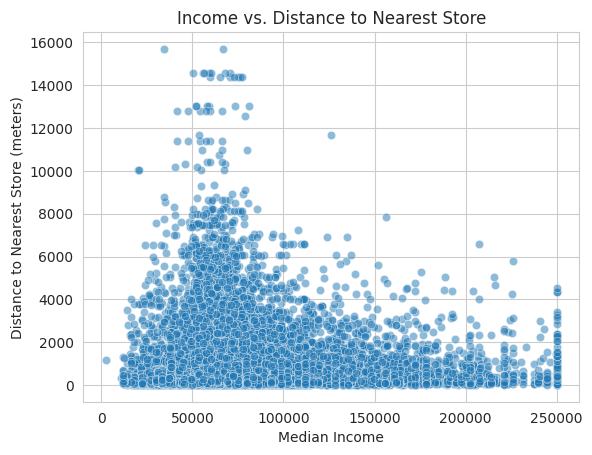

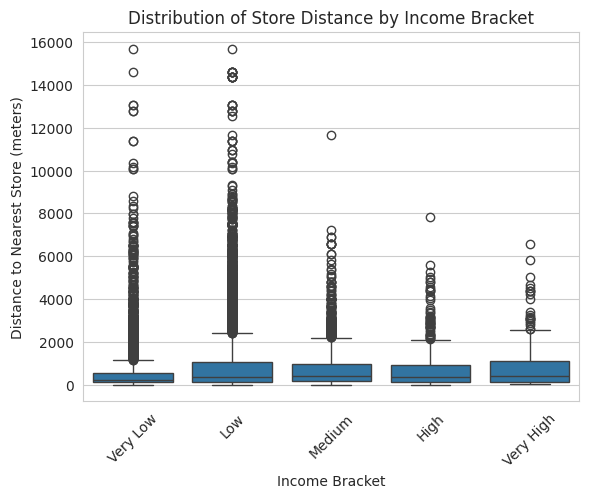

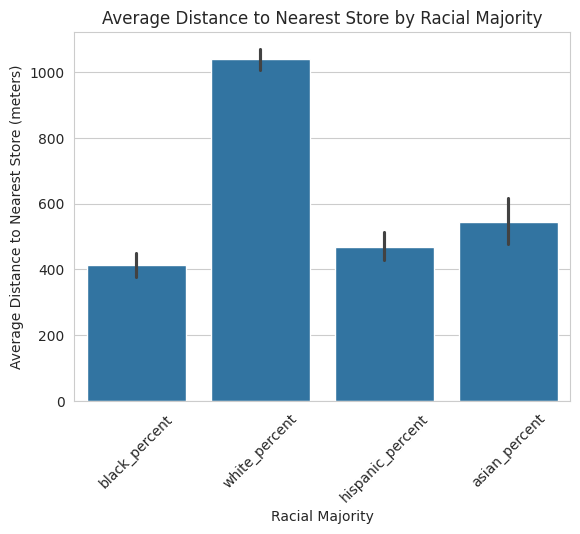

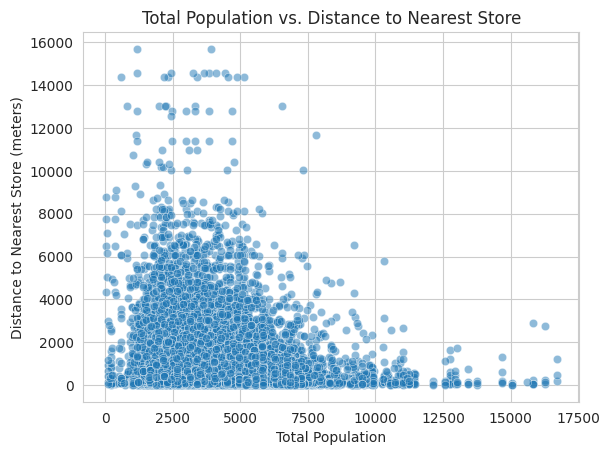

In [83]:
# Loads the merged dataframe
df = pd.read_csv('merged_census_store_data.csv')

# 1. Scatter plot: Income vs. Distance to Nearest Store
sns.scatterplot(x='median_income', y='distance_to_nearest_store', data=df, alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Distance to Nearest Store (meters)')
plt.title('Income vs. Distance to Nearest Store')
plt.show()

## Plot 2: Distance to Nearest Store by Income Bracket 


In this plot very low income people have the shortest distance to grocery stores. This is likely do to many very low income people living in more urban areas. Every other income group has relatively similar values for distance to weather stations. High income has a slightly lower value and very high income a slightly larger value. Very high income people most likely have a slightly larger distance to grocery stores as they are more likely to live in suburban areas. 

In [ ]:
# 2. Box plot: Distance to Nearest Store by Income Bracket
df['income_bracket'] = pd.cut(df['median_income'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
sns.boxplot(x='income_bracket', y='distance_to_nearest_store', data=df)
plt.xlabel('Income Bracket')
plt.ylabel('Distance to Nearest Store (meters)')
plt.title('Distribution of Store Distance by Income Bracket')
plt.xticks(rotation=45)
plt.show()

## Plot 3: Average Distance to Nearest Store by Racial Majority


The average distance to weather stations is highest among white people. This again is likely do to more white people living in suburban areas. The values are more equal for other racial groups where the distance is around 400 meters for all of them. The lowest average distance is for Black people. This might be due to the higher population of Black people in New York City where everyone has a shorter distance to grocery stores. 

In [ ]:
# 3. Bar plot: Average Distance to Nearest Store by Racial Majority
df['racial_majority'] = df[['white_percent', 'black_percent', 'asian_percent', 'hispanic_percent']].idxmax(axis=1)
sns.barplot(x='racial_majority', y='distance_to_nearest_store', data=df, estimator=lambda x: x.mean())
plt.xlabel('Racial Majority')
plt.ylabel('Average Distance to Nearest Store (meters)')
plt.title('Average Distance to Nearest Store by Racial Majority')
plt.xticks(rotation=45)
plt.show()

## Plot 4: Total Population vs. Distance to Nearest Store
 

Smaller census populations have further distances to travel to grocery stores. This makes sense as census tracts with smaller populations are likely in more rural areas. In rural areas everything is more spread out and thus the distance to travel to grocery stores is further. 

In [ ]:
# 4. Scatter plot: Total Population vs. Distance to Nearest Store
sns.scatterplot(x='total_pop', y='distance_to_nearest_store', data=df, alpha=0.5)
plt.xlabel('Total Population')
plt.ylabel('Distance to Nearest Store (meters)')
plt.title('Total Population vs. Distance to Nearest Store')
plt.show()

## Questions for reviewers

1. How do we calculate density of grocery stores for individual tracts? Since tracts are irregularly shaped, we are not certain how to search for grocery stores within it. Initial idea was 1 mile radius. Then we thought about getting data for entire area of tract, assume the area is circular, to find radius (r) and then using that radius to search (using latitude and longitude) for grocery stores in that circular area?

2. Given the limitations of our data and analysis methods, what additional data sources or techniques would you recommend to strengthen our findings? For example, would incorporating public transportation data or health outcome statistics be feasible and valuable?

3. How can we better visualize or quantify the potential disparities in food access among different racial groups based on our current data? Are there any specific visualization techniques or metrics you would suggest?

4. What potential confounding factors should we consider when interpreting the relationship between income levels and store counts? How might we control for these in our analysis?

5. Given that our data is a snapshot in time, how would you suggest we frame our conclusions to account for this limitation? Are there ways we could hint at potential trends even without time-series data?





## References

Geopandas intro tutorial:
https://geopandas.org/en/stable/getting_started/introduction.html

Spacial data links: 
https://walker-data.com/posts/proximity-analysis/
https://michaelminn.net/tutorials/python-proximity/index.html

Geopandas, for geospatial operations in Python, guide to getting started:
https://geopandas.org/en/stable/getting_started/introduction.html
https://geopandas.org/en/stable/docs/user_guide.html

Shapely for geometric operations:
https://shapely.readthedocs.io/en/stable/manual.html 

Conducting Geospatial Analysis in GeoPandas:
https://geog-312.gishub.org/book/geospatial/geopandas.html 

Figuring out pd.DF.apply: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

Using Lambda function to PD Dataframes:
https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/

Coordinate Reference Systems Info:
https://docs.qgis.org/latest/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

Geopandas and Shapeley guide:
https://www.learndatasci.com/tutorials/geospatial-data-python-geopandas-shapely/ 

API Sources: 
https://pygis.io/docs/d_access_census.html
https://n8henrie.com/uploads/2017/11/plotting-us-census-data-with-python-and-geopandas.html
